In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
import datetime
from copy import deepcopy

# 一、数据准备

## 1.1 读取日度行情表

表内字段就是 Backtrader 默认情况下要求输入的 7 个字段： 'datetime' 、'open'、'high'、'low'、'close'、'volume'、'openinterest'，外加一个 'sec_code' 股票代码字段。

In [2]:
daily_price = pd.read_csv("./data/daily_price.csv", parse_dates=['datetime'])
daily_price

,datetime,sec_code,open,high,low,close,volume,openinterest
0,2019-01-02,600466.SH,33.064891,33.496709,31.954503,32.386321,10629352,0
1,2019-01-02,603228.SH,50.660230,51.458513,50.394136,51.120778,426147,0
2,2019-01-02,600315.SH,148.258423,150.480132,148.258423,149.558935,2138556,0
3,2019-01-02,000750.SZ,49.512579,53.154883,48.715825,51.561375,227557612,0
4,2019-01-02,002588.SZ,36.608672,36.608672,35.669988,35.763857,2841517,0
...,...,...,...,...,...,...,...,...
255967,2021-01-28,600717.SH,121.489201,122.011736,120.705400,120.966667,6022213,0
255968,2021-01-28,300558.SZ,134.155888,137.600704,130.700970,131.569750,5330301,0
255969,2021-01-28,600171.SH,39.774873,39.830040,38.864630,38.947380,12354183,0
255970,2021-01-28,600597.SH,47.190201,49.243025,46.250355,46.423484,32409940,0


In [3]:
# 提取 600315.SH 上海家化
data1 = daily_price.query(f"sec_code=='600315.SH'").set_index('datetime').drop(columns=['sec_code'])
data1 

,open,high,low,close,volume,openinterest
datetime,,,,,,
2019-01-02,148.258423,150.480132,148.258423,149.558935,2138556,0
2019-01-03,149.504747,150.209191,142.514493,143.598253,3032080,0
2019-01-04,140.997228,146.524406,140.076032,146.307654,2957692,0
2019-01-07,147.120474,147.337226,142.839621,143.652441,5665587,0
2019-01-08,143.435689,143.923381,140.997228,142.622869,2009482,0
...,...,...,...,...,...,...
2021-01-22,206.677537,208.876234,201.455631,203.159621,5404602,0
2021-01-25,201.895370,207.227211,198.487390,204.423872,5416695,0
2021-01-26,203.929165,208.216625,198.762227,199.421836,4215020,0


# 二、简单均线策略-可视化

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['figure.figsize'] = 15, 15

BUY 100 close 171.01739112
CLOSE 100 close 167.87448596
BUY 100 close 154.59842106
CLOSE 100 close 166.51978546
BUY 100 close 173.21505054
CLOSE 100 close 180.31626674
BUY 100 close 188.34610352
CLOSE 100 close 181.57263576
BUY 100 close 167.58870232
CLOSE 100 close 163.92884474
BUY 100 close 169.00894556
CLOSE 100 close 161.03373352
BUY 100 close 138.03671798
CLOSE 100 close 255.86228216
BUY 100 close 254.33278944
CLOSE 100 close 236.36124998
BUY 100 close 236.35994900000003
CLOSE 100 close 213.32859583
BUY 100 close 228.99431338
CLOSE 100 close 224.2671144
BUY 100 close 235.70033984
CLOSE 100 close 219.48494799
BUY 100 close 214.09813985
CLOSE 100 close 208.60139685
BUY 100 close 219.26507827
CLOSE 100 close 206.51263451
BUY 100 close 205.24838362
CLOSE 100 close 192.60587472
BUY 100 close 203.15962128


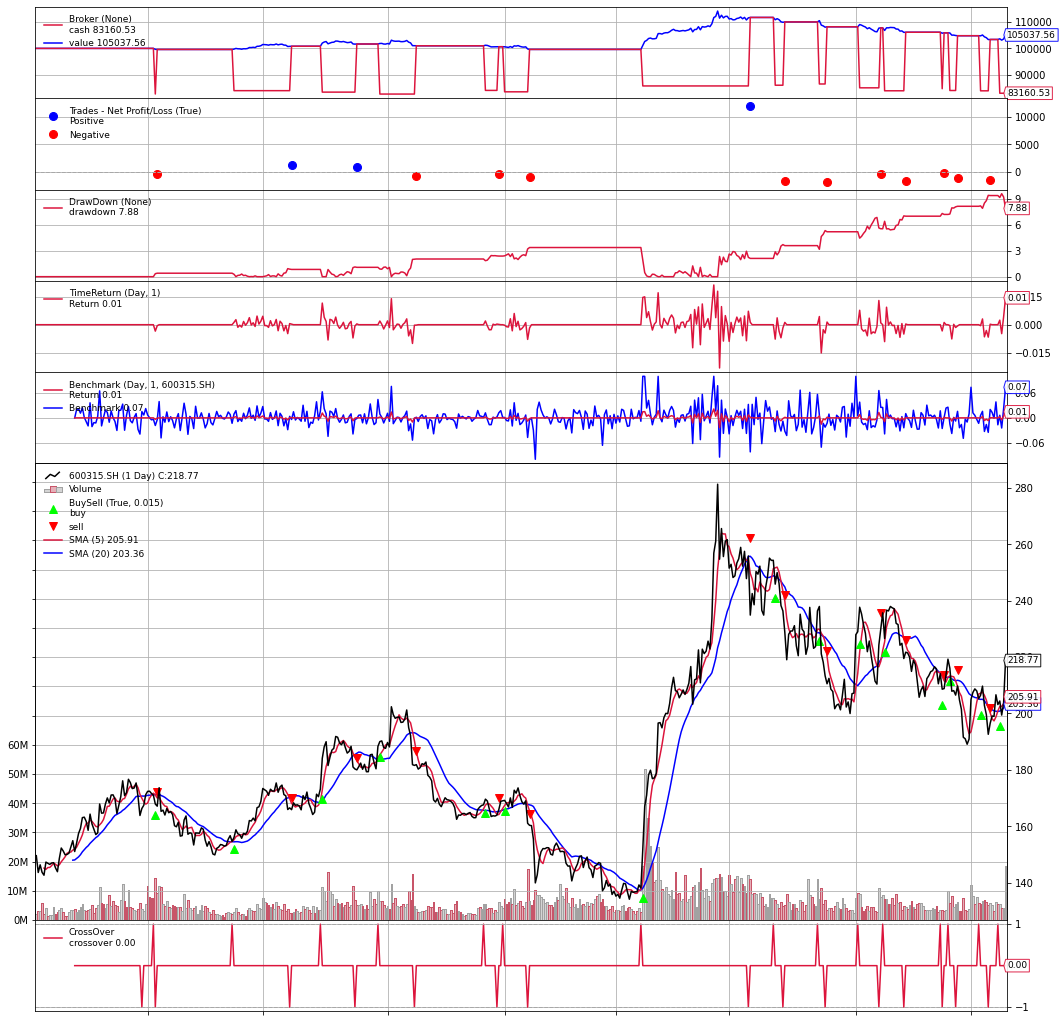

[[<Figure size 1080x1080 with 8 Axes>]]

In [15]:
import backtrader as bt

class TestStrategy(bt.Strategy):
    params = (
        ('period1', 5),
        ('period2', 20),
    )

    def __init__(self):
        sma1 = bt.indicators.SMA(period=self.p.period1)  # 短期均线
        sma2 = bt.indicators.SMA(period=self.p.period2)  # 长期均线
        # 短期均线上穿长期均线，取值为 1；短期均线下穿长期均线，取值为 -1；相等，取值为 0
        self.crossover = bt.indicators.CrossOver(sma1, sma2)  
        self.order = None
        
    def next(self):
        # 下穿卖出
        if self.position:
            if self.crossover < 0.0: 
                self.order = self.close()
                print('CLOSE {} close {}'.format(self.position.size, self.data.close[0]))
        # 上穿买入
        else:
            if self.crossover > 0.0:
                self.order = self.buy(size=100)
                print('BUY {} close {}'.format(100, self.data.close[0]))

        
cerebro = bt.Cerebro()
cerebro.broker.set_cash(100000)
st_date = datetime.datetime(2019,1,2)
ed_date = datetime.datetime(2021,1,28)
datafeed1 = bt.feeds.PandasData(dataname=data1, fromdate=st_date, todate=ed_date)
cerebro.adddata(datafeed1, name='600315.SH')
cerebro.addstrategy(TestStrategy)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)
cerebro.addobserver(bt.observers.Benchmark, data=datafeed1)
# cerebro.addobserver(bt.observers.Broker)
# cerebro.addobserver(bt.observers.Trades)
# cerebro.addobserver(bt.observers.BuySell)
# cerebro.addobserver(bt.observers.TimeReturn)
rasult = cerebro.run()
cerebro.plot(iplot=False)

# 三、如何读取 observers 中的数据

2019-01-30T00:00:00
getcash 当前可用资金 100000.0
getvalue 当前总资产 100000.0
2019-01-29T00:00:00
self.stats 当前可用资金 100000.0
self.stats 当前总资产 100000.0
self.stats 最大回撤 0.0
self.stats 收益 0.0
2019-01-31T00:00:00
getcash 当前可用资金 100000.0
getvalue 当前总资产 100000.0
2019-01-30T00:00:00
self.stats 当前可用资金 100000.0
self.stats 当前总资产 100000.0
self.stats 最大回撤 0.0
self.stats 收益 0.0
2019-02-01T00:00:00
getcash 当前可用资金 100000.0
getvalue 当前总资产 100000.0
2019-01-31T00:00:00
self.stats 当前可用资金 100000.0
self.stats 当前总资产 100000.0
self.stats 最大回撤 0.0
self.stats 收益 0.0
2019-02-11T00:00:00
getcash 当前可用资金 100000.0
getvalue 当前总资产 100000.0
2019-02-01T00:00:00
self.stats 当前可用资金 100000.0
self.stats 当前总资产 100000.0
self.stats 最大回撤 0.0
self.stats 收益 0.0
2019-02-12T00:00:00
getcash 当前可用资金 100000.0
getvalue 当前总资产 100000.0
2019-02-11T00:00:00
self.stats 当前可用资金 100000.0
self.stats 当前总资产 100000.0
self.stats 最大回撤 0.0
self.stats 收益 0.0
2019-02-13T00:00:00
getcash 当前可用资金 100000.0
getvalue 当前总资产 100000.0
2019-02-12T00:00:00
self.stats 当前可用资金

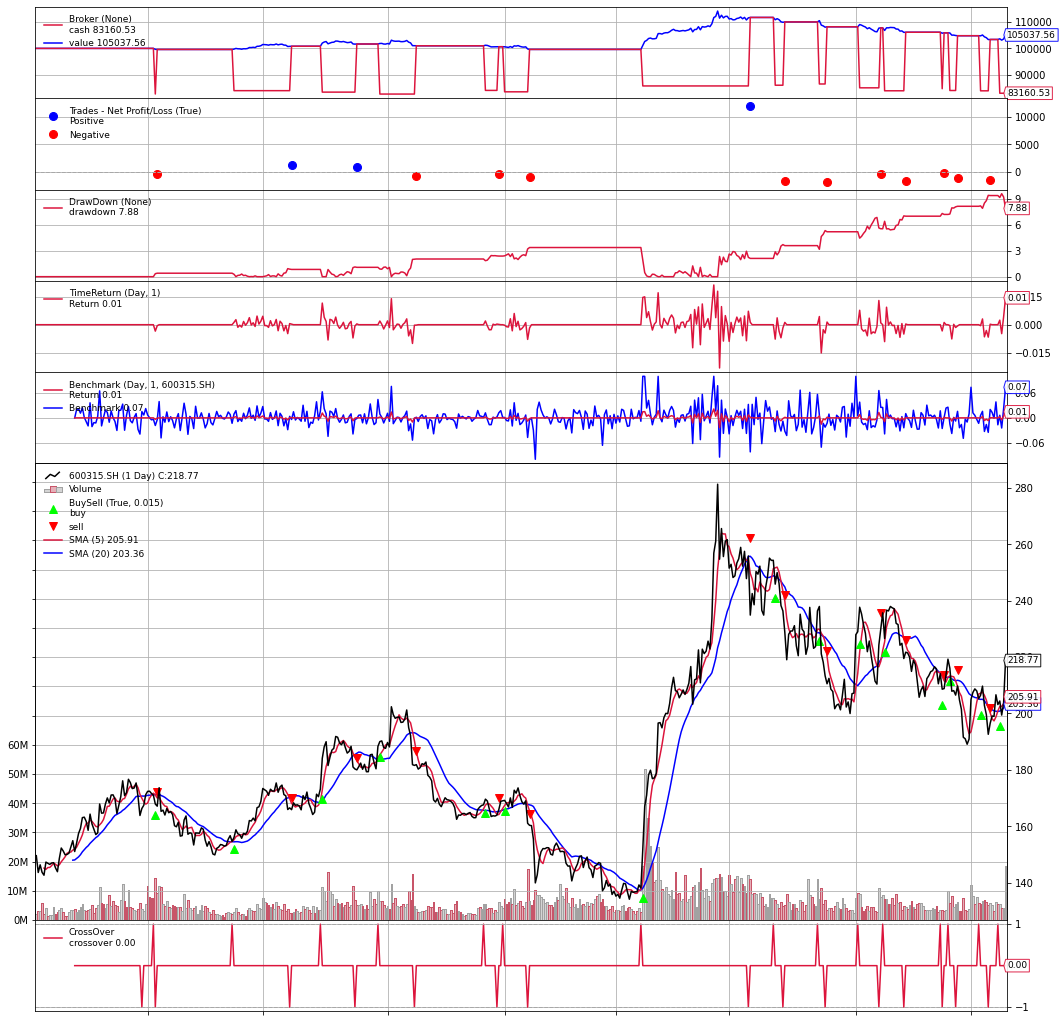

[[<Figure size 1080x1080 with 8 Axes>]]

In [46]:
import backtrader as bt

class TestStrategy(bt.Strategy):
    params = (
        ('period1', 5),
        ('period2', 20),
    )

    def __init__(self):
        sma1 = bt.indicators.SMA(period=self.p.period1)  # 短期均线
        sma2 = bt.indicators.SMA(period=self.p.period2)  # 长期均线
        # 短期均线上穿长期均线，取值为 1；短期均线下穿长期均线，取值为 -1；相等，取值为 0
        self.crossover = bt.indicators.CrossOver(sma1, sma2)  
        self.order = None
        
    def next(self):
        print(bt.num2date(self.data.datetime[0]).isoformat())
        print('getcash 当前可用资金', self.broker.getcash())
        print('getvalue 当前总资产', self.broker.getvalue())
        print(bt.num2date(self.data.datetime[-1]).isoformat())
        print('self.stats 当前可用资金', self.stats.broker.cash[0])
        print('self.stats 当前总资产', self.stats.broker.value[0])
        print('self.stats 最大回撤', self.stats.drawdown.drawdown[0])
        print('self.stats 收益', self.stats.timereturn.line[0])
        # 下穿卖出
        if self.position:
            if self.crossover < 0.0: 
                self.order = self.close()
                print(bt.num2date(self.data.datetime[0]).isoformat())
                print('CLOSE {} close {}'.format(self.position.size, self.data.close[0]))
        # 上穿买入
        else:
            if self.crossover > 0.0:
                self.order = self.buy(size=100)
                print(bt.num2date(self.data.datetime[0]).isoformat())
                print('BUY {} close {}'.format(100, self.data.close[0]))
                
    def stop(self):
        print('---------stop----------')
        print(bt.num2date(self.data.datetime[0]).isoformat())
        print('getcash 当前可用资金', self.broker.getcash())
        print('getvalue 当前总资产', self.broker.getvalue())
        print(bt.num2date(self.data.datetime[-1]).isoformat())
        print('self.stats 当前可用资金', self.stats.broker.cash[0])
        print('self.stats 当前总资产', self.stats.broker.value[0])
        print('self.stats 最大回撤', self.stats.drawdown.drawdown[0])
        print('self.stats 收益', self.stats.timereturn.line[0])

        
cerebro = bt.Cerebro()
cerebro.broker.set_cash(100000)
st_date = datetime.datetime(2019,1,2)
ed_date = datetime.datetime(2021,1,28)
datafeed1 = bt.feeds.PandasData(dataname=data1, fromdate=st_date, todate=ed_date)
cerebro.adddata(datafeed1, name='600315.SH')
cerebro.addanalyzer(bt.analyzers.TimeDrawDown, _name='_TimeDrawDown')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')
cerebro.addstrategy(TestStrategy)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)
cerebro.addobserver(bt.observers.Benchmark, data=datafeed1)
rasult = cerebro.run()
cerebro.plot(iplot=False)

In [34]:
rasult[0].analyzers._TimeReturn.get_analysis()

OrderedDict([(datetime.datetime(2019, 1, 2, 0, 0), 0.0),
             (datetime.datetime(2019, 1, 3, 0, 0), 0.0),
             (datetime.datetime(2019, 1, 4, 0, 0), 0.0),
             (datetime.datetime(2019, 1, 7, 0, 0), 0.0),
             (datetime.datetime(2019, 1, 8, 0, 0), 0.0),
             (datetime.datetime(2019, 1, 9, 0, 0), 0.0),
             (datetime.datetime(2019, 1, 10, 0, 0), 0.0),
             (datetime.datetime(2019, 1, 11, 0, 0), 0.0),
             (datetime.datetime(2019, 1, 14, 0, 0), 0.0),
             (datetime.datetime(2019, 1, 15, 0, 0), 0.0),
             (datetime.datetime(2019, 1, 16, 0, 0), 0.0),
             (datetime.datetime(2019, 1, 17, 0, 0), 0.0),
             (datetime.datetime(2019, 1, 18, 0, 0), 0.0),
             (datetime.datetime(2019, 1, 21, 0, 0), 0.0),
             (datetime.datetime(2019, 1, 22, 0, 0), 0.0),
             (datetime.datetime(2019, 1, 23, 0, 0), 0.0),
             (datetime.datetime(2019, 1, 24, 0, 0), 0.0),
             (dateti

In [43]:
rasult[0].analyzers._TimeDrawDown.get_analysis()

OrderedDict([('maxdrawdown', 9.580115462743626), ('maxdrawdownperiod', 150)])

# 四、将 observers 中的数据读到本地

2019-04-04T00:00:00
BUY 100 close 171.01739112
2019-04-08T00:00:00
CLOSE 100 close 167.87448596
2019-06-06T00:00:00
BUY 100 close 154.59842106
2019-07-19T00:00:00
CLOSE 100 close 166.51978546
2019-08-12T00:00:00
BUY 100 close 173.21505054
2019-09-05T00:00:00
CLOSE 100 close 180.31626674
2019-09-24T00:00:00
BUY 100 close 188.34610352
2019-10-28T00:00:00
CLOSE 100 close 181.57263576
2019-12-17T00:00:00
BUY 100 close 167.58870232
2019-12-26T00:00:00
CLOSE 100 close 163.92884474
2019-12-31T00:00:00
BUY 100 close 169.00894556
2020-01-20T00:00:00
CLOSE 100 close 161.03373352
2020-04-21T00:00:00
BUY 100 close 138.03671798
2020-07-15T00:00:00
CLOSE 100 close 255.86228216
2020-08-03T00:00:00
BUY 100 close 254.33278944
2020-08-10T00:00:00
CLOSE 100 close 236.36124998
2020-09-03T00:00:00
BUY 100 close 236.35994900000003
2020-09-09T00:00:00
CLOSE 100 close 213.32859583
2020-10-12T00:00:00
BUY 100 close 228.99431338
2020-10-27T00:00:00
CLOSE 100 close 224.2671144
2020-10-29T00:00:00
BUY 100 close 2

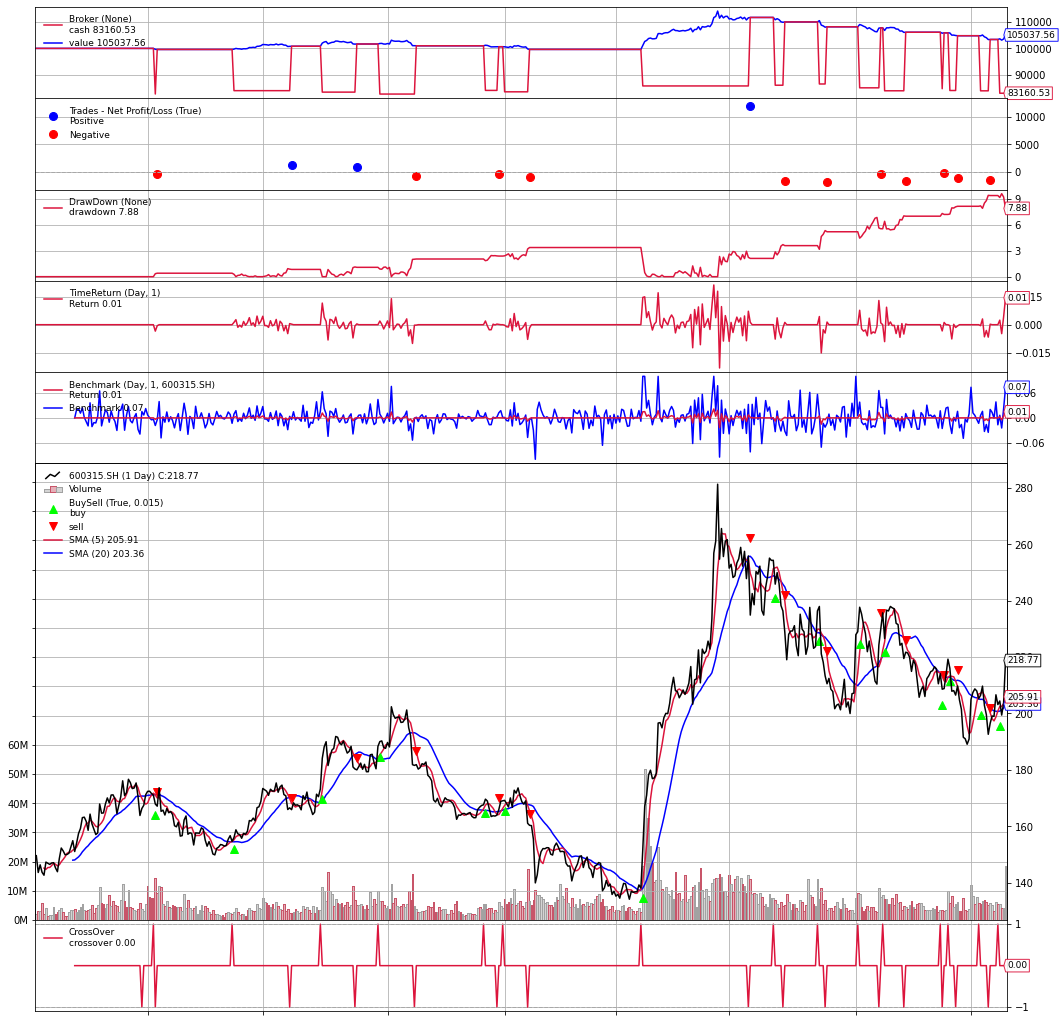

[[<Figure size 1080x1080 with 8 Axes>]]

In [67]:
import backtrader as bt
import csv

class TestStrategy(bt.Strategy):
    params = (
        ('period1', 5),
        ('period2', 20),
    )

    def __init__(self):
        sma1 = bt.indicators.SMA(period=self.p.period1)  # 短期均线
        sma2 = bt.indicators.SMA(period=self.p.period2)  # 长期均线
        # 短期均线上穿长期均线，取值为 1；短期均线下穿长期均线，取值为 -1；相等，取值为 0
        self.crossover = bt.indicators.CrossOver(sma1, sma2)  
        self.order = None
        
    def start(self):
        self.mystats = csv.writer(open("mystats.csv", "w"))
        self.mystats.writerow(['datetime',
                               'drawdown', 'maxdrawdown', 
                               'timereturn',
                               'value', 'cash'])
        
    def next(self): 
        self.mystats.writerow([self.data.datetime.date(-1).strftime('%Y-%m-%d'),
                               '%.4f' % self.stats.drawdown.drawdown[0],
                               '%.4f' % self.stats.drawdown.maxdrawdown[0],
                               '%.4f' % self.stats.timereturn.line[0],
                               '%.4f' % self.stats.broker.value[0],
                               '%.4f' % self.stats.broker.cash[0]])
        
        if self.position:
            if self.crossover < 0.0: 
                self.order = self.close()
                print(bt.num2date(self.data.datetime[0]).isoformat())
                print('CLOSE {} close {}'.format(self.position.size, self.data.close[0]))
        # 上穿买入
        else:
            if self.crossover > 0.0:
                self.order = self.buy(size=100)
                print(bt.num2date(self.data.datetime[0]).isoformat())
                print('BUY {} close {}'.format(100, self.data.close[0]))
                
    def stop(self):  
        self.mystats.writerow([self.data.datetime.date(0).strftime('%Y-%m-%d'),
                               '%.4f' % self.stats.drawdown.drawdown[0],
                               '%.4f' % self.stats.drawdown.maxdrawdown[0],
                               '%.4f' % self.stats.timereturn.line[0],
                               '%.4f' % self.stats.broker.value[0],
                               '%.4f' % self.stats.broker.cash[0]])

        
cerebro = bt.Cerebro()
cerebro.broker.set_cash(100000)
st_date = datetime.datetime(2019,1,2)
ed_date = datetime.datetime(2021,1,28)
datafeed1 = bt.feeds.PandasData(dataname=data1, fromdate=st_date, todate=ed_date)
cerebro.adddata(datafeed1, name='600315.SH')
cerebro.addanalyzer(bt.analyzers.TimeDrawDown, _name='_TimeDrawDown')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')
cerebro.addstrategy(TestStrategy)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)
cerebro.addobserver(bt.observers.Benchmark, data=datafeed1)
rasult = cerebro.run()
cerebro.plot(iplot=False)

# 五、部分修改样式

BUY 100 close 171.01739112
CLOSE 100 close 167.87448596
BUY 100 close 154.59842106
CLOSE 100 close 166.51978546
BUY 100 close 173.21505054
CLOSE 100 close 180.31626674
BUY 100 close 188.34610352
CLOSE 100 close 181.57263576
BUY 100 close 167.58870232
CLOSE 100 close 163.92884474
BUY 100 close 169.00894556
CLOSE 100 close 161.03373352
BUY 100 close 138.03671798
CLOSE 100 close 255.86228216
BUY 100 close 254.33278944
CLOSE 100 close 236.36124998
BUY 100 close 236.35994900000003
CLOSE 100 close 213.32859583
BUY 100 close 228.99431338
CLOSE 100 close 224.2671144
BUY 100 close 235.70033984
CLOSE 100 close 219.48494799
BUY 100 close 214.09813985
CLOSE 100 close 208.60139685
BUY 100 close 219.26507827
CLOSE 100 close 206.51263451
BUY 100 close 205.24838362
CLOSE 100 close 192.60587472
BUY 100 close 203.15962128


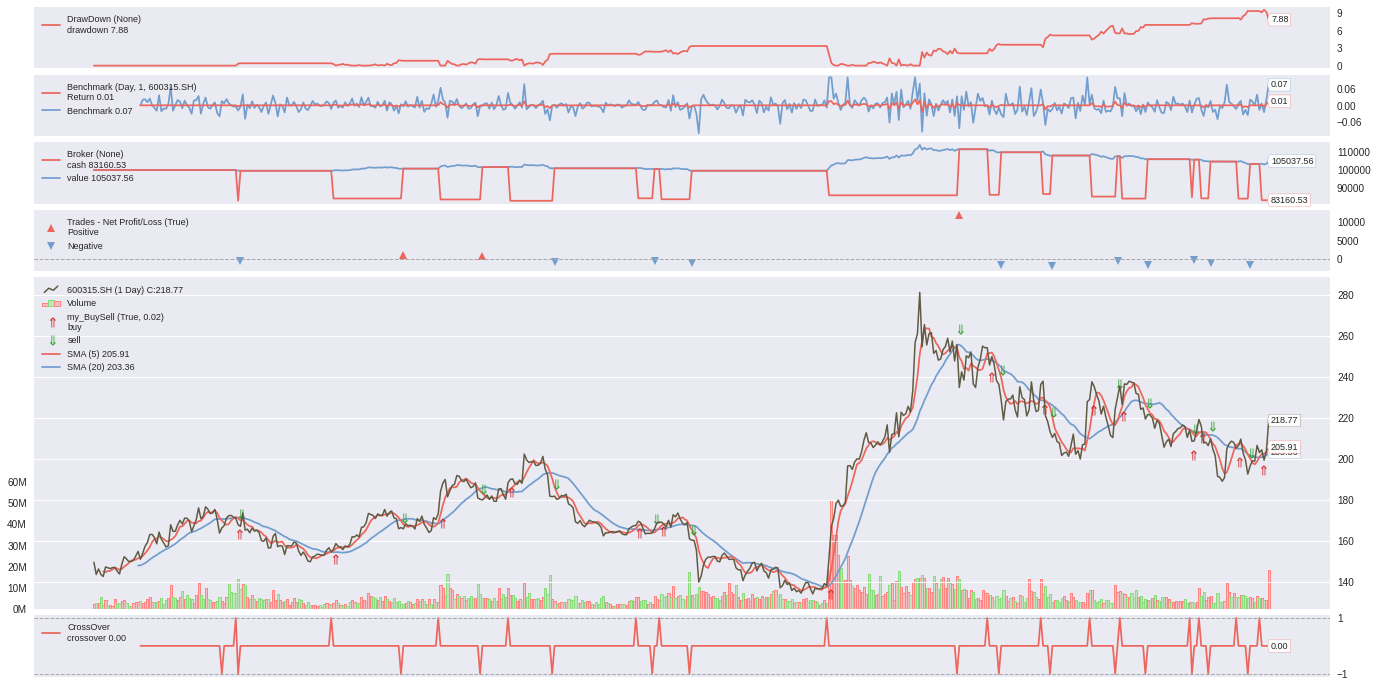

[[<Figure size 1440x720 with 7 Axes>]]

In [17]:

import backtrader as bt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 20, 10

class my_Trades(bt.observers.Trades):
    plotlines = dict(
    pnlplus=dict(_name='Positive',
                 marker='^', color='#ed665d',
                 markersize=8.0, fillstyle='full'),
    pnlminus=dict(_name='Negative',
                  marker='v', color='#729ece',
                  markersize=8.0, fillstyle='full'))


class my_BuySell(bt.observers.BuySell):
    
    params = (('barplot', True), ('bardist', 0.02))
    
    plotlines = dict(
    buy=dict(marker=r'$\Uparrow$', markersize=10.0, color='#d62728' ),
    sell=dict(marker=r'$\Downarrow$', markersize=10.0, color='#2ca02c'))
    
    

class TestStrategy(bt.Strategy):
    params = (
        ('period1', 5),
        ('period2', 20),
    )

    def __init__(self):
        sma1 = bt.indicators.SMA(period=self.p.period1)  # 短期均线
        sma2 = bt.indicators.SMA(period=self.p.period2)  # 长期均线
        
        # 短期均线上穿长期均线，取值为 1；短期均线下穿长期均线，取值为 -1；相等，取值为 0
        self.crossover = bt.indicators.CrossOver(sma1, sma2, plot=True)  
        self.order = None
        
    def next(self):
        # 下穿卖出
        if self.position:
            if self.crossover < 0.0: 
                self.order = self.close()
                print('CLOSE {} close {}'.format(self.position.size, self.data.close[0]))
        # 上穿买入
        else:
            if self.crossover > 0.0:
                self.order = self.buy(size=100)
                print('BUY {} close {}'.format(100, self.data.close[0]))

        
cerebro1 = bt.Cerebro(stdstats=False)
cerebro1.broker.set_cash(100000)
st_date = datetime.datetime(2019,1,2)
ed_date = datetime.datetime(2021,1,28)
datafeed1 = bt.feeds.PandasData(dataname=data1, fromdate=st_date, todate=ed_date)
cerebro1.adddata(datafeed1, name='600315.SH')
cerebro1.addstrategy(TestStrategy)
cerebro1.addobserver(bt.observers.DrawDown)
cerebro1.addobserver(bt.observers.Benchmark, data=datafeed1)
cerebro1.addobserver(bt.observers.Broker)
cerebro1.addobserver(my_Trades)
cerebro1.addobserver(my_BuySell)
rasult = cerebro1.run()
colors = ['#729ece', '#ff9e4a', '#67bf5c', '#ed665d', '#ad8bc9', '#a8786e', '#ed97ca', '#a2a2a2', '#cdcc5d', '#6dccda']
tab10_index = [3, 0, 2, 1, 2, 4, 5, 6, 7, 8, 9]
cerebro1.plot(iplot=False,  
              style='line', 
              lcolors=colors ,
              plotdist=0.1, 
              bartrans=0.2, 
              volup='#ff9896', 
              voldown='#98df8a', 
              loc='#5f5a41',
              grid=False)

### 将上图转换为蜡烛图，由于蜡烛图排列较紧密，通过设置 numfigs=2，将其分为 2 部分绘制

BUY 100 close 171.01739112
CLOSE 100 close 167.87448596
BUY 100 close 154.59842106
CLOSE 100 close 166.51978546
BUY 100 close 173.21505054
CLOSE 100 close 180.31626674
BUY 100 close 188.34610352
CLOSE 100 close 181.57263576
BUY 100 close 167.58870232
CLOSE 100 close 163.92884474
BUY 100 close 169.00894556
CLOSE 100 close 161.03373352
BUY 100 close 138.03671798
CLOSE 100 close 255.86228216
BUY 100 close 254.33278944
CLOSE 100 close 236.36124998
BUY 100 close 236.35994900000003
CLOSE 100 close 213.32859583
BUY 100 close 228.99431338
CLOSE 100 close 224.2671144
BUY 100 close 235.70033984
CLOSE 100 close 219.48494799
BUY 100 close 214.09813985
CLOSE 100 close 208.60139685
BUY 100 close 219.26507827
CLOSE 100 close 206.51263451
BUY 100 close 205.24838362
CLOSE 100 close 192.60587472
BUY 100 close 203.15962128


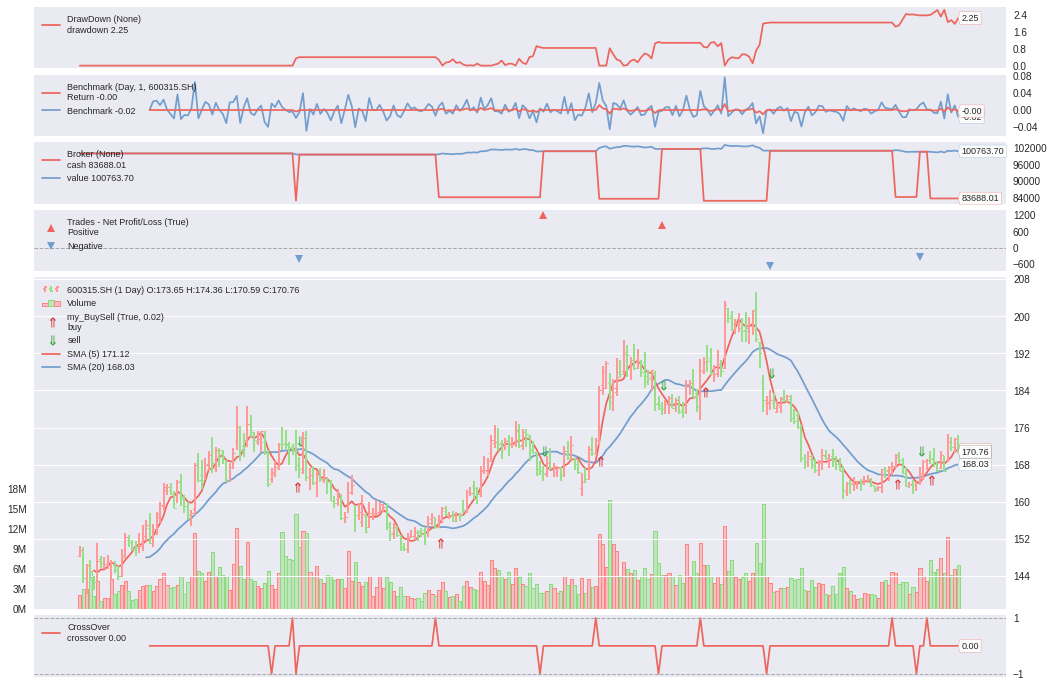

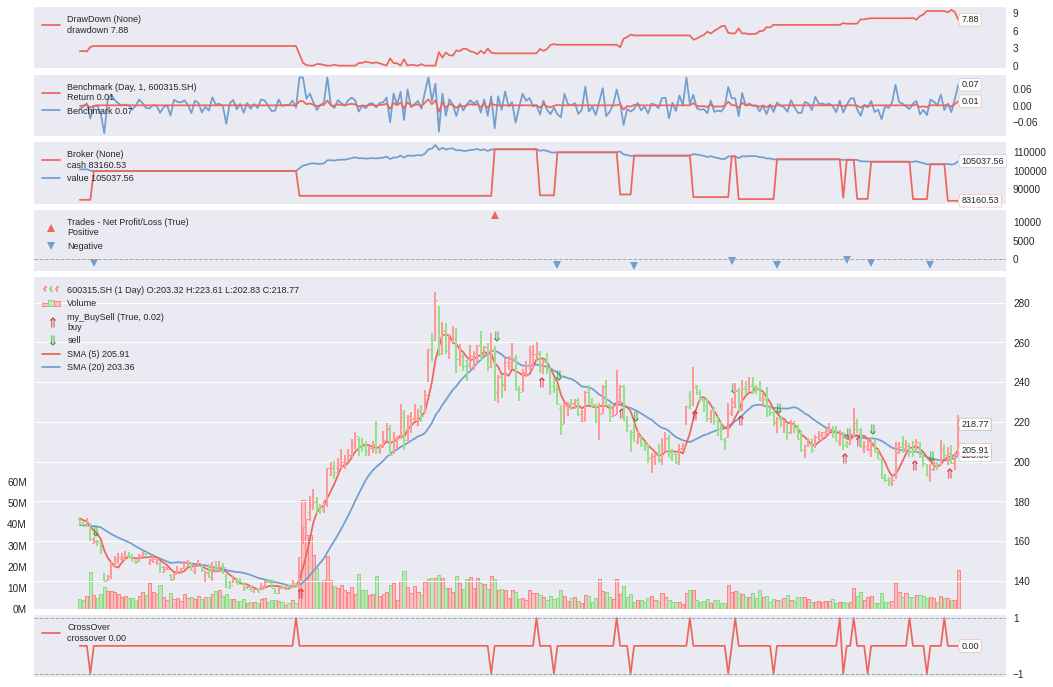

[[<Figure size 1080x720 with 7 Axes>, <Figure size 1080x720 with 7 Axes>]]

In [18]:
import backtrader as bt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 15, 10


class my_Trades(bt.observers.Trades):
    plotlines = dict(
    pnlplus=dict(_name='Positive',
                 marker='^', color='#ed665d',
                 markersize=8.0, fillstyle='full'),
    pnlminus=dict(_name='Negative',
                  marker='v', color='#729ece',
                  markersize=8.0, fillstyle='full'))


class my_BuySell(bt.observers.BuySell):
    
    params = (('barplot', True), ('bardist', 0.02))
    
    plotlines = dict(
    buy=dict(marker=r'$\Uparrow$', markersize=10.0, color='#d62728' ),
    sell=dict(marker=r'$\Downarrow$', markersize=10.0, color='#2ca02c'))
    

class TestStrategy(bt.Strategy):
    params = (
        ('period1', 5),
        ('period2', 20),
    )

    def __init__(self):
        sma1 = bt.indicators.SMA(period=self.p.period1)  # 短期均线
        sma2 = bt.indicators.SMA(period=self.p.period2)  # 长期均线
        # 短期均线上穿长期均线，取值为 1；短期均线下穿长期均线，取值为 -1；相等，取值为 0
        self.crossover = bt.indicators.CrossOver(sma1, sma2, plot=True)  
        self.order = None
        
    def next(self):
        # 下穿卖出
        if self.position:
            if self.crossover < 0.0: 
                self.order = self.close()
                print('CLOSE {} close {}'.format(self.position.size, self.data.close[0]))
        # 上穿买入
        else:
            if self.crossover > 0.0:
                self.order = self.buy(size=100)
                print('BUY {} close {}'.format(100, self.data.close[0]))

        
cerebro1 = bt.Cerebro(stdstats=False)
cerebro1.broker.set_cash(100000)
st_date = datetime.datetime(2019,1,2)
ed_date = datetime.datetime(2021,1,28)
datafeed1 = bt.feeds.PandasData(dataname=data1, fromdate=st_date, todate=ed_date)
cerebro1.adddata(datafeed1, name='600315.SH')
cerebro1.addstrategy(TestStrategy)
cerebro1.addobserver(bt.observers.DrawDown)
cerebro1.addobserver(bt.observers.Benchmark, data=datafeed1)
cerebro1.addobserver(bt.observers.Broker)
cerebro1.addobserver(my_Trades)
cerebro1.addobserver(my_BuySell)
rasult = cerebro1.run()
colors = ['#729ece', '#ff9e4a', '#67bf5c', '#ed665d', '#ad8bc9', '#a8786e', '#ed97ca', '#a2a2a2', '#cdcc5d', '#6dccda']
tab10_index = [3, 0, 2, 1, 2, 4, 5, 6, 7, 8, 9]
cerebro1.plot(iplot=False,  style='candel', 
              lcolors=colors , 
              plotdist=0.1, 
              bartrans=0.2, 
              barup = '#ff9896', bardown='#98df8a',
              volup='#ff9896', voldown='#98df8a',  numfigs=2,
              grid=False)

# 六、基于净值曲线进行可视化

In [19]:
class TestStrategy(bt.Strategy):
    params = (
        ('period1', 5),
        ('period2', 20),
    )

    def __init__(self):
        sma1 = bt.indicators.SMA(period=self.p.period1)  # 短期均线
        sma2 = bt.indicators.SMA(period=self.p.period2)  # 长期均线
        # 短期均线上穿长期均线，取值为 1；短期均线下穿长期均线，取值为 -1；相等，取值为 0
        self.crossover = bt.indicators.CrossOver(sma1, sma2, plot=True)  
        self.order = None
        
    def next(self):
        # 下穿卖出
        if self.position:
            if self.crossover < 0.0: 
                self.order = self.close()
                print('CLOSE {} close {}'.format(self.position.size, self.data.close[0]))
        # 上穿买入
        else:
            if self.crossover > 0.0:
                self.order = self.buy(size=100)
                print('BUY {} close {}'.format(100, self.data.close[0]))

        
cerebro1 = bt.Cerebro(stdstats=False)
cerebro1.broker.set_cash(100000)
st_date = datetime.datetime(2019,1,2)
ed_date = datetime.datetime(2021,1,28)
datafeed1 = bt.feeds.PandasData(dataname=data1, fromdate=st_date, todate=ed_date)
cerebro1.adddata(datafeed1, name='600315.SH')
cerebro1.addstrategy(TestStrategy)
cerebro1.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')
result = cerebro1.run()

BUY 100 close 171.01739112
CLOSE 100 close 167.87448596
BUY 100 close 154.59842106
CLOSE 100 close 166.51978546
BUY 100 close 173.21505054
CLOSE 100 close 180.31626674
BUY 100 close 188.34610352
CLOSE 100 close 181.57263576
BUY 100 close 167.58870232
CLOSE 100 close 163.92884474
BUY 100 close 169.00894556
CLOSE 100 close 161.03373352
BUY 100 close 138.03671798
CLOSE 100 close 255.86228216
BUY 100 close 254.33278944
CLOSE 100 close 236.36124998
BUY 100 close 236.35994900000003
CLOSE 100 close 213.32859583
BUY 100 close 228.99431338
CLOSE 100 close 224.2671144
BUY 100 close 235.70033984
CLOSE 100 close 219.48494799
BUY 100 close 214.09813985
CLOSE 100 close 208.60139685
BUY 100 close 219.26507827
CLOSE 100 close 206.51263451
BUY 100 close 205.24838362
CLOSE 100 close 192.60587472
BUY 100 close 203.15962128


/home/anaconda3/envs/quant/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


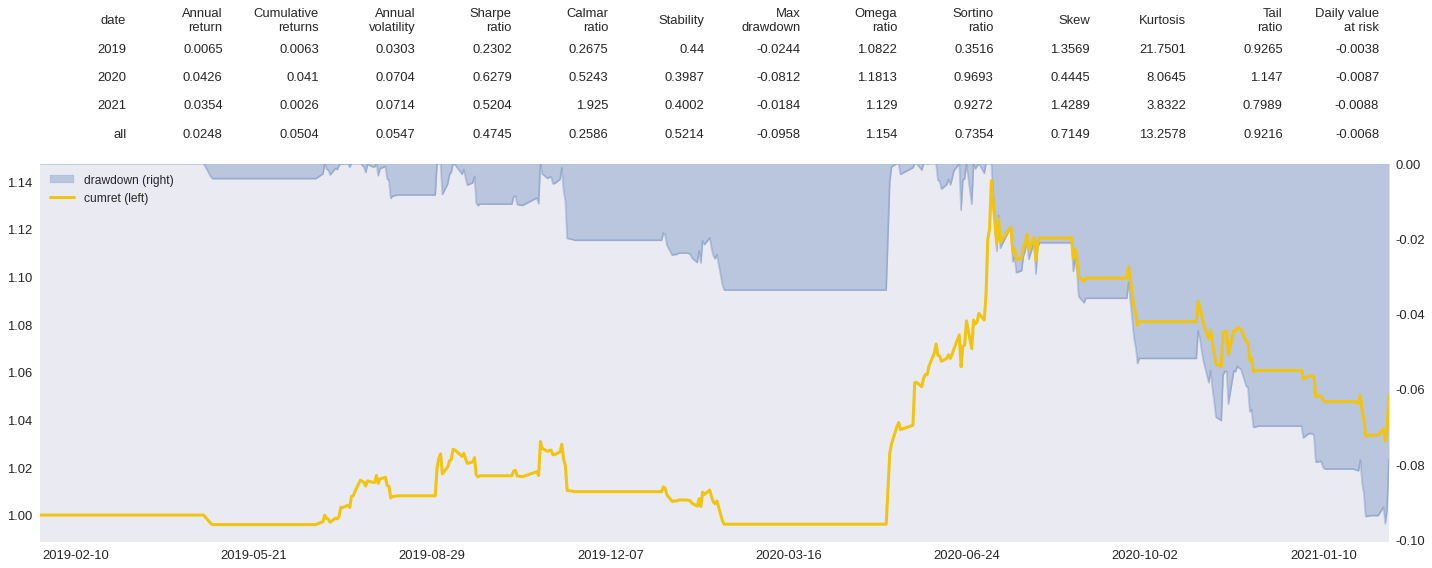

In [20]:
# 提取收益序列
pnl = pd.Series(result[0].analyzers._TimeReturn.get_analysis())
# 计算累计收益
cumulative = (pnl + 1).cumprod()
# 计算回撤序列
max_return = cumulative.cummax()
drawdown = (cumulative - max_return) / max_return
# 计算收益评价指标
import pyfolio as pf
# 按年统计收益指标
perf_stats_year = (pnl).groupby(pnl.index.to_period('y')).apply(lambda data: pf.timeseries.perf_stats(data)).unstack()
# 统计所有时间段的收益指标
perf_stats_all = pf.timeseries.perf_stats((pnl)).to_frame(name='all')
perf_stats = pd.concat([perf_stats_year, perf_stats_all.T], axis=0)
perf_stats_ = round(perf_stats,4).reset_index()


# 绘制图形
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import matplotlib.ticker as ticker  # 导入设置坐标轴的模块
plt.style.use('seaborn')  # plt.style.use('dark_background')


fig, (ax0, ax1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1.5, 4]}, figsize=(20,8))
cols_names = ['date', 'Annual\nreturn', 'Cumulative\nreturns', 'Annual\nvolatility',
       'Sharpe\nratio', 'Calmar\nratio', 'Stability', 'Max\ndrawdown',
       'Omega\nratio', 'Sortino\nratio', 'Skew', 'Kurtosis', 'Tail\nratio',
       'Daily value\nat risk']

# 绘制表格
ax0.set_axis_off()  # 除去坐标轴
table = ax0.table(cellText = perf_stats_.values, 
                bbox=(0,0,1,1),  # 设置表格位置， (x0, y0, width, height)
                rowLoc = 'right',  # 行标题居中
                cellLoc='right' ,
                colLabels = cols_names, # 设置列标题
                colLoc = 'right',  # 列标题居中
                edges = 'open' # 不显示表格边框
                )
table.set_fontsize(13)

# 绘制累计收益曲线
ax2 = ax1.twinx()
ax1.yaxis.set_ticks_position('right') # 将回撤曲线的 y 轴移至右侧
ax2.yaxis.set_ticks_position('left') # 将累计收益曲线的 y 轴移至左侧
# 绘制回撤曲线
drawdown.plot.area(ax=ax1, label='drawdown (right)', rot=0, alpha=0.3, fontsize=13, grid=False)
# 绘制累计收益曲线
(cumulative).plot(ax=ax2, color='#F1C40F' , lw=3.0, label='cumret (left)', rot=0, fontsize=13, grid=False)
# 不然 x 轴留有空白
ax2.set_xbound(lower=cumulative.index.min(), upper=cumulative.index.max())
# 主轴定位器：每 5 个月显示一个日期：根据具体天数来做排版
ax2.xaxis.set_major_locator(ticker.MultipleLocator(100)) 
# 同时绘制双轴的图例
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2,l1+l2, fontsize=12, loc='upper left', ncol=1)

fig.tight_layout() # 规整排版
plt.show()

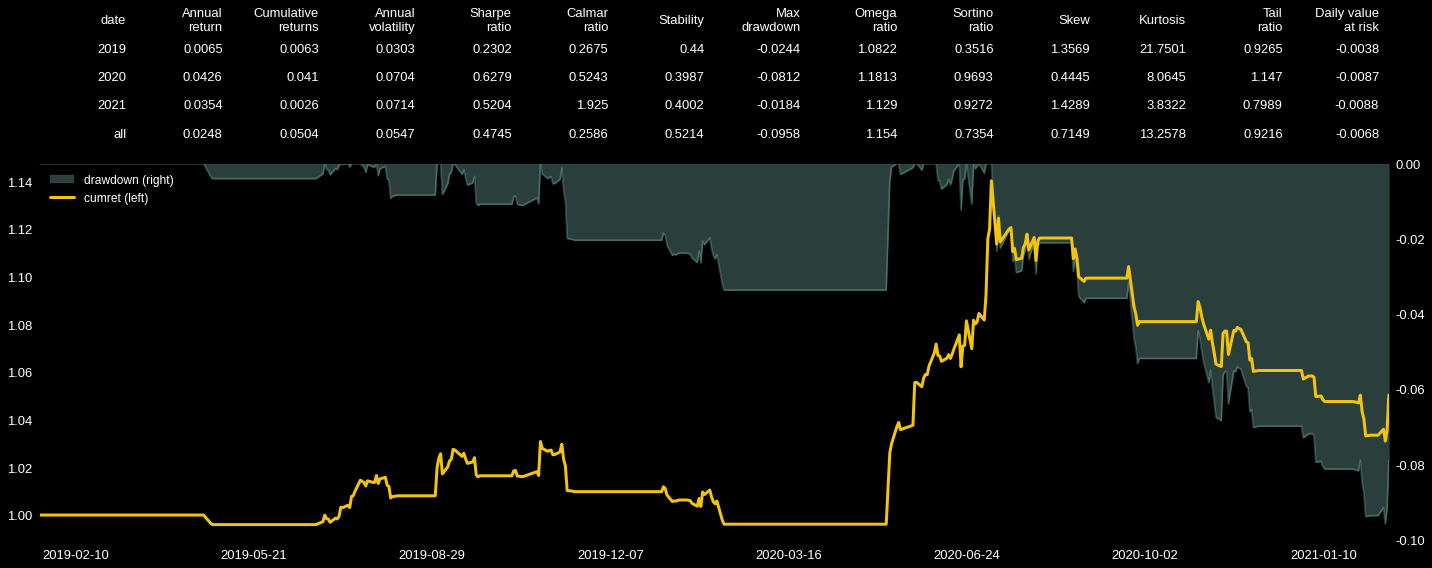

In [21]:
# 提取收益序列
pnl = pd.Series(result[0].analyzers._TimeReturn.get_analysis())
# 计算累计收益
cumulative = (pnl + 1).cumprod()
# 计算回撤序列
max_return = cumulative.cummax()
drawdown = (cumulative - max_return) / max_return
# 计算收益评价指标
import pyfolio as pf
# 按年统计收益指标
perf_stats_year = (pnl).groupby(pnl.index.to_period('y')).apply(lambda data: pf.timeseries.perf_stats(data)).unstack()
# 统计所有时间段的收益指标
perf_stats_all = pf.timeseries.perf_stats((pnl)).to_frame(name='all')
perf_stats = pd.concat([perf_stats_year, perf_stats_all.T], axis=0)
perf_stats_ = round(perf_stats,4).reset_index()


# 绘制图形
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import matplotlib.ticker as ticker  # 导入设置坐标轴的模块
plt.style.use('dark_background')  # plt.style.use('seaborn')


fig, (ax0, ax1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1.5, 4]}, figsize=(20,8) )
cols_names = ['date', 'Annual\nreturn', 'Cumulative\nreturns', 'Annual\nvolatility',
       'Sharpe\nratio', 'Calmar\nratio', 'Stability', 'Max\ndrawdown',
       'Omega\nratio', 'Sortino\nratio', 'Skew', 'Kurtosis', 'Tail\nratio',
       'Daily value\nat risk']

# 绘制表格
ax0.set_axis_off()  # 除去坐标轴
table = ax0.table(cellText = perf_stats_.values, 
                bbox=(0,0,1,1),  # 设置表格位置， (x0, y0, width, height)
                rowLoc = 'right',  # 行标题居中
                cellLoc='right' ,
                colLabels = cols_names, # 设置列标题
                colLoc = 'right',  # 列标题居中
                edges = 'open' # 不显示表格边框
                )
table.set_fontsize(13)

# 绘制累计收益曲线
ax2 = ax1.twinx()
ax1.yaxis.set_ticks_position('right') # 将回撤曲线的 y 轴移至右侧
ax2.yaxis.set_ticks_position('left') # 将累计收益曲线的 y 轴移至左侧
# 绘制回撤曲线
drawdown.plot.area(ax=ax1, label='drawdown (right)', rot=0, alpha=0.3, fontsize=13, grid=False)
# 绘制累计收益曲线
(cumulative).plot(ax=ax2, color='#F1C40F' , lw=3.0, label='cumret (left)', rot=0, fontsize=13, grid=False)
# 不然 x 轴留有空白
ax2.set_xbound(lower=cumulative.index.min(), upper=cumulative.index.max())
# 主轴定位器：每 5 个月显示一个日期：根据具体天数来做排版
ax2.xaxis.set_major_locator(ticker.MultipleLocator(100)) 
# 同时绘制双轴的图例
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2,l1+l2, fontsize=12, loc='upper left', ncol=1)

fig.tight_layout() # 规整排版
plt.show()